In [1]:
# Imports
%matplotlib notebook
import numpy as np
import pylgmath
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from matplotlib.text import Annotation
from pylgmath.so3.operations import vec2rot
from utils import plotting
from utils import sim

In [2]:
# camera parameters
f_u = 100 # focal length in horizonal pixels
f_v = 100 # focal length in vertical pixels
c_u = 50 # pinhole projection in horizonal pixels
c_v = 50 # pinhold projection in vertical pixels
b = 0.2 # baseline (meters)

M = sim.make_stereo_camera_matrix(f_u, f_v, c_u, c_v, b)

<IPython.core.display.Javascript object>


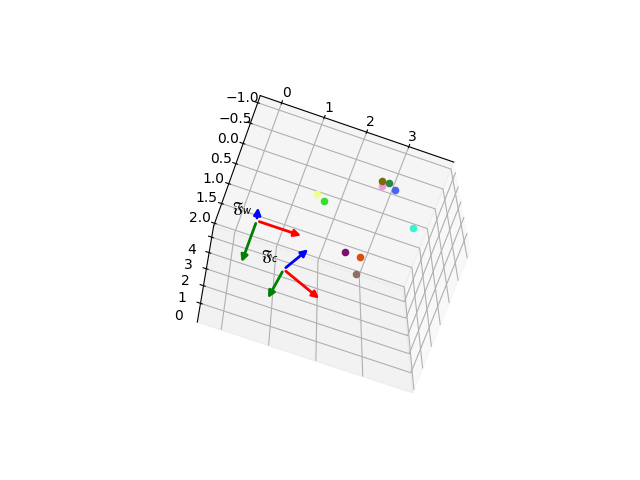

<IPython.core.display.Javascript object>


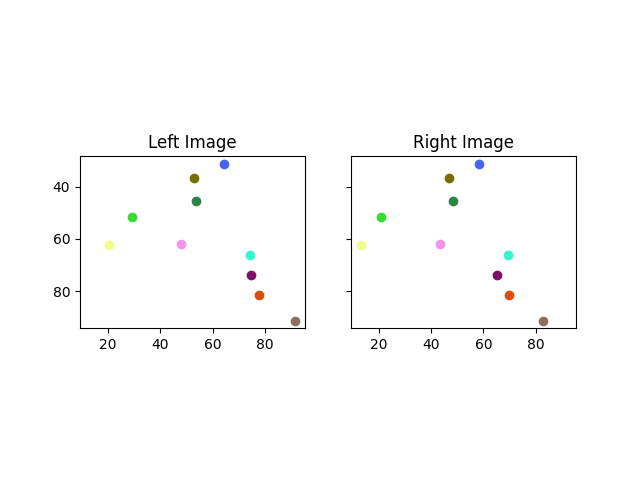

In [4]:
# make random camera pose
a = np.random.rand(3, 1)
theta = np.random.rand() * 2*np.pi
C_wc = vec2rot(theta * a/np.linalg.norm(a))
T_wc = np.eye(4)
T_wc[:3, :3] = C_wc
T_wc[:-1, -1] = [3*np.random.rand(), 3*np.random.rand(), 0]

# make sim instance
fig, ax, p_w, colors = sim.make_stereo_sim_instance(10, T_wc, np.array([[-1,1], [-1, 1], [2, 5]]))

# Generative camera model 
T_cw = np.linalg.inv(T_wc)
y = sim.generative_camera_model(M, T_cw, p_w)
camfig, (l_ax, r_ax) = sim.render_camera_points(y, colors)